In [2]:
import pandas as pd
import numpy as np
import nmslib

%load_ext autoreload
%autoreload 2
from matrix_factorization import Matrix_Factorization_V2

from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -100.

# VBD DATA

In [3]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']
def preprocess_data(raw_data='training-vbd-floor1.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json('training-vbd-floor1.json')
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

## Split train set & test set

In [4]:
training_data = rssi_dataset_df.sample(frac=0.9, random_state=10)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 72
No. of testing examples: 8


# Gaussian Processes Regression

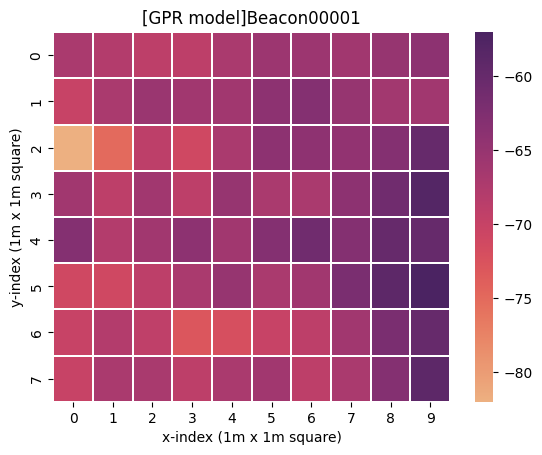

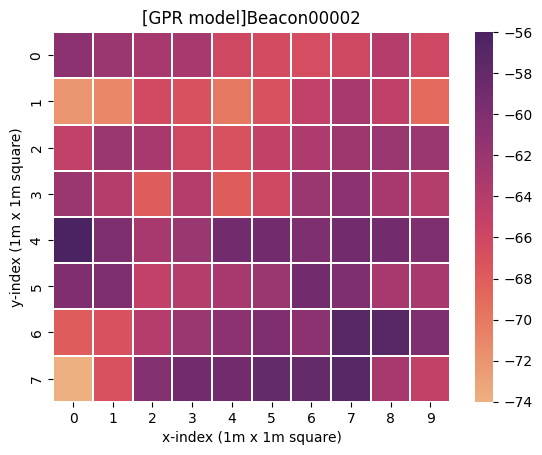

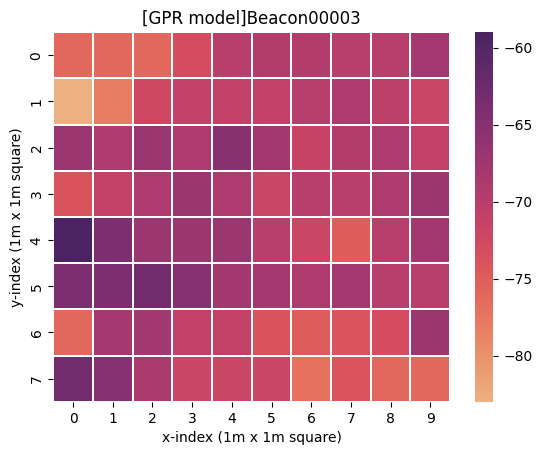

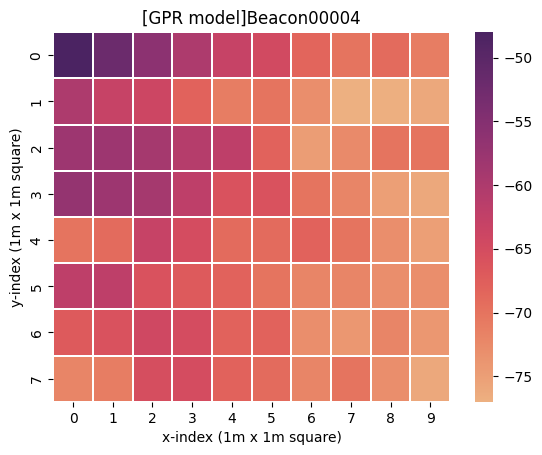

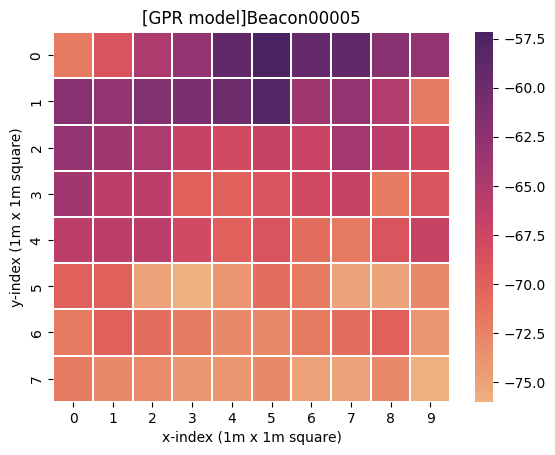

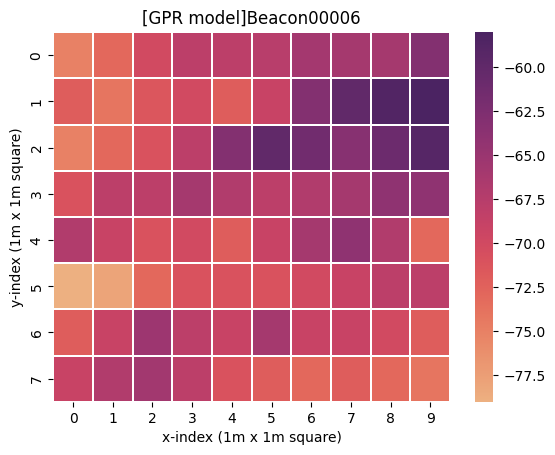

In [6]:
from helper import plot_radiomap

# init test matrix
n_rows = 8
n_cols = 10
radiomap = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomaps = []
radiomaps_test = []
for beacon in beacons:
    # sample inputs and outputs
    X = training_data[['row', 'col']].to_numpy()
    Y = training_data[[beacon]].to_numpy()

    # standardscale
    X_scaler = preprocessing.StandardScaler().fit(X)
    Y_scaler = preprocessing.StandardScaler().fit(Y)
    # transform
    X_scaled = X_scaler.transform(X)
    Y_scaled = Y_scaler.transform(Y)

    # init kernel
    kernel = k.RBF(length_scale=[1., 1.], length_scale_bounds=(1e-2,1e2))
    # run GPR
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)
    gp.fit(X_scaled, Y_scaled.reshape(-1,1))

    # PLOT
    for i in range(n_rows):
        for j in range(n_cols):
            x_pred = X_scaler.transform(np.array([[i,j]]))
            y_mean,y_std = gp.predict(x_pred,return_std=True)
            radiomap[i, j] = Y_scaler.inverse_transform(np.array([y_mean]))
    plot_radiomap(radiomap, min_data=radiomap.min(), max_data=radiomap.max(), beacon=beacon)
    # [END] PLOT

    # add radiomap
    radiomaps.append(radiomap.flatten())


In [7]:
import helper

Test data (1,8): [-64 -63 -71 -77 -69 -56]
Test coord [106.66884247  10.81085997]
3 nearest neighbours (array idx): [19 18 26] [0.00052577 0.00053471 0.00069916]
3 nearest neighbours (matrix idx):
([[1 9]
 [1 8]
 [2 6]])
Centroid cell: ([1.77492715 8.31573885])
Centroid coord: ([106.66884196  10.81085749])
Error: 0.3309639050529563


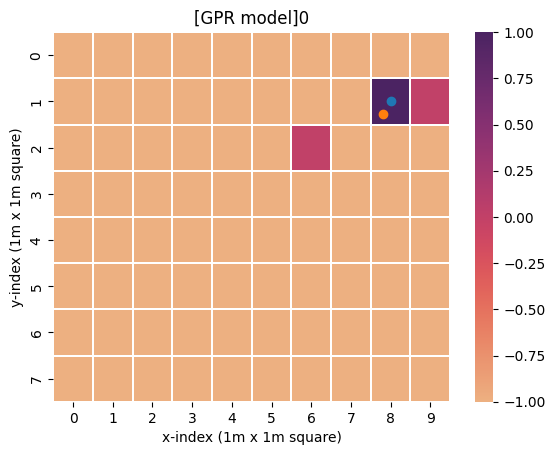

Test data (0,5): [-64 -67 -66 -68 -58 -68]
Test coord [106.66881828  10.81086056]
3 nearest neighbours (array idx): [14 13  6] [0.00010228 0.00034869 0.00035238]
3 nearest neighbours (matrix idx):
([[1 4]
 [1 3]
 [0 6]])
Centroid cell: ([1.31670947 4.6813478 ])
Centroid coord: ([106.66881487  10.81085249])
Error: 1.1563761407934379


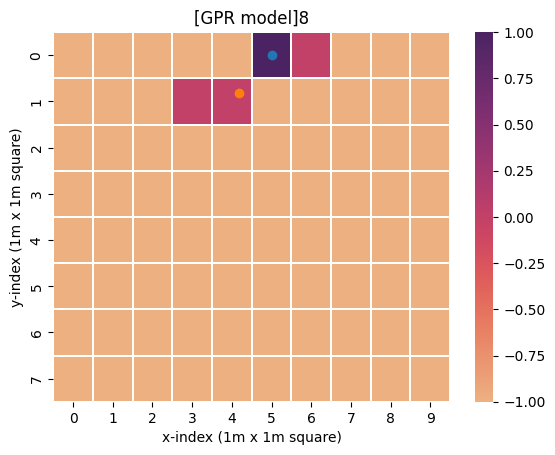

Test data (0,6): [-65 -65 -64 -72 -56 -66]
Test coord [106.66882538  10.81086285]
3 nearest neighbours (array idx): [ 7 14  6] [0.0007503  0.00092202 0.00096369]
3 nearest neighbours (matrix idx):
([[0 7]
 [1 4]
 [0 6]])
Centroid cell: ([0.81390914 6.25793486])
Centroid coord: ([106.66882458  10.81085993])
Error: 0.39640192241749556


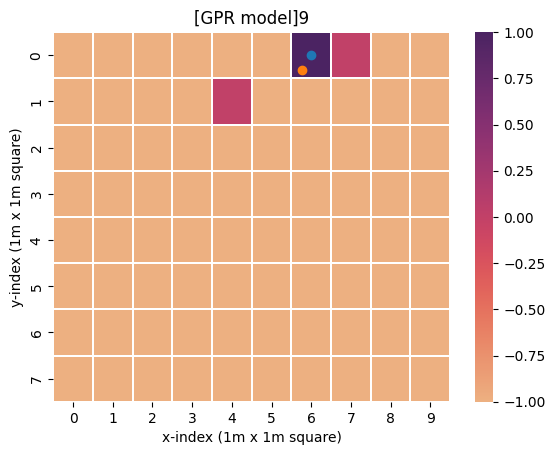

Test data (1,2): [-69 -71 -73 -64 -65 -73]
Test coord [106.66879996  10.81084603]
3 nearest neighbours (array idx): [12  4 32] [0.00029731 0.00035942 0.00044572]
3 nearest neighbours (matrix idx):
([[1 2]
 [0 4]
 [3 2]])
Centroid cell: ([1.70320951 3.16329141])
Centroid coord: ([106.66880526  10.81084602])
Error: 0.6937215546985596


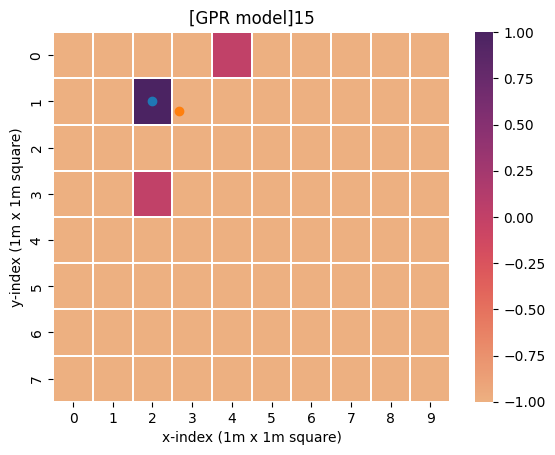

Test data (2,6): [-62 -63 -68 -68 -66 -61]
Test coord [106.66883122  10.81084779]
3 nearest neighbours (array idx): [28 25 16] [0.00010502 0.00014454 0.00047183]
3 nearest neighbours (matrix idx):
([[2 8]
 [2 5]
 [1 6]])
Centroid cell: ([2.38580497 7.15329958])
Centroid coord: ([106.66883551  10.81085019])
Error: 0.663204981101101


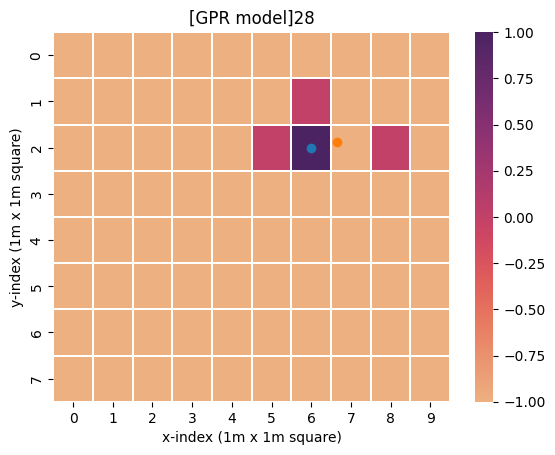

Test data (2,7): [-66 -63 -66 -69 -66 -63]
Test coord [106.6688383   10.81085015]
3 nearest neighbours (array idx): [36 25 28] [0.00034654 0.00044501 0.00045884]
3 nearest neighbours (matrix idx):
([[3 6]
 [2 5]
 [2 8]])
Centroid cell: ([2.89463433 6.78879025])
Centroid coord: ([106.66883442  10.81084551])
Error: 0.8133606624592004


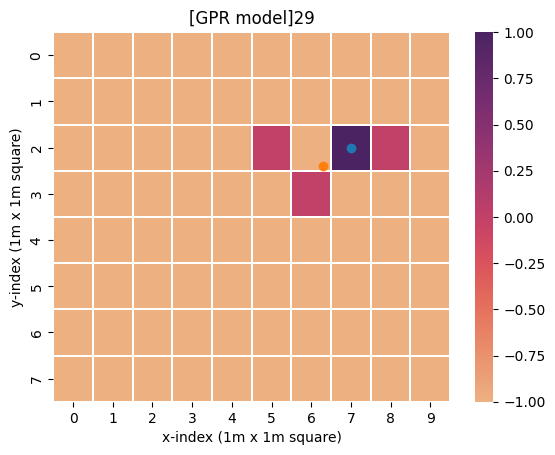

Test data (6,2): [-67 -67 -67 -66 -71 -68]
Test coord [106.66881486  10.81080771]
3 nearest neighbours (array idx): [61 34 62] [6.0796738e-05 1.9764900e-04 3.9964914e-04]
3 nearest neighbours (matrix idx):
([[6 1]
 [3 4]
 [6 2]])
Centroid cell: ([5.86782684 2.23638791])
Centroid coord: ([106.66881113  10.8108119 ])
Error: 0.6849337484872623


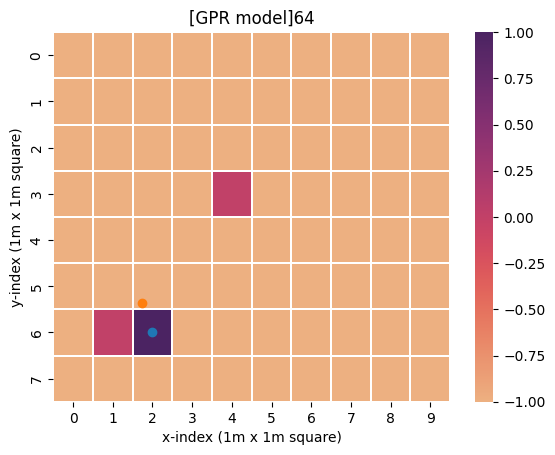

Test data (7,2): [-67 -59 -70 -65 -75 -69]
Test coord [106.66881784  10.81080004]
3 nearest neighbours (array idx): [73 74 72] [0.00016904 0.00021625 0.00023556]
3 nearest neighbours (matrix idx):
([[7 3]
 [7 4]
 [7 2]])
Centroid cell: ([7.49999977 3.52564162])
Centroid coord: ([106.66882502  10.81080263])
Error: 1.0256416150015013


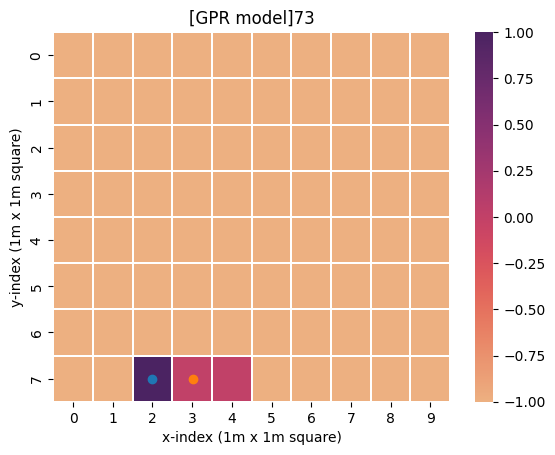

RMSE:  0.7671048120552839


In [26]:
bounds = np.array([
    [106.6687777176107,10.81085184372406  ],
    [106.66884879614959,10.81087456718684 ],
    [106.6688717625642,10.810815288584667 ],
    [106.66880185749176,10.810789848180981]
    ])
helper.check_position_pred_accuracy(radiomaps=radiomaps, testing_data=testing_data, bounds=bounds)